## 1. Dependencies Installation and Import

In [3]:
# Import dependencies
!pip install category-encoders xgboost -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, confusion_matrix
from category_encoders import TargetEncoder
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

## 2. Data Ingestion

In [5]:
# Ingesting data
data = pd.read_csv('credit_card_transactions.csv')
print(f"Data Shape: {data.shape}")
data.head()

Data Shape: (1296675, 24)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


## 3. Data Exploration

In [6]:
# Exploring data structure
data.info()

print('*****************\n')

# Check for class imbalance
fraud_summary = data['is_fraud'].value_counts(normalize=True).mul(100).round(2)
print(f"Fraud Distribution:\n{fraud_summary}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

#### **Findings**

##### **1. Dataset Overview**
- **Total Records**: 1,296,675
- **Total Features**: 24 columns
  - 6 numeric columns (`float64`/`int64`).
  - 12 categorical/object columns.
  - merch_zipcode has **missing** values
- **Target Label**: `is_fraud`

##### **2. Class Imbalance**
- **Fraud Transactions (1)**: **0.58%** of the total dataset.
- **Non-Fraud Transactions (0)**: **99.42%** of the total dataset.

##### **Key Insight**
The dataset is **highly imbalanced**, with fraudulent transactions being less than 1% of the total. This imbalance requires:
- Appropriate metrics for model evaluation (e.g., Recall, Precision, F1 Score, Weighted Cost-Aware Accuracy).
- Techniques such as **stratified sampling**, **SMOTE**, or **cost-sensitive learning** to handle imbalance.

In [10]:
# Function: to display details for each columns

def display_unique_values(data):
    """
    Display unique values and the number of unique values for each column in the dataframe.

    Parameters:
    data (pd.DataFrame): The dataframe to analyze.

    Returns:
    None
    """
    for column in data.columns:
        unique_values = data[column].unique()
        print(f"Column: {column}")
        print(f"Data Type: {data[column].dtype}")
        print(f"Number of Unique Values: {len(unique_values)}")
        print(f"Unique Values: {unique_values[:2]}...")  # Show the first 2 unique values for brevity
        print("-" * 50)

# Call the function on your dataset
print("Unique Value Analysis:\n")
display_unique_values(data)

Unique Value Analysis:

Column: Unnamed: 0
Data Type: int64
Number of Unique Values: 1296675
Unique Values: [0 1]...
--------------------------------------------------
Column: trans_date_trans_time
Data Type: object
Number of Unique Values: 1274791
Unique Values: ['2019-01-01 00:00:18' '2019-01-01 00:00:44']...
--------------------------------------------------
Column: cc_num
Data Type: int64
Number of Unique Values: 983
Unique Values: [2703186189652095     630423337322]...
--------------------------------------------------
Column: merchant
Data Type: object
Number of Unique Values: 693
Unique Values: ['fraud_Rippin, Kub and Mann' 'fraud_Heller, Gutmann and Zieme']...
--------------------------------------------------
Column: category
Data Type: object
Number of Unique Values: 14
Unique Values: ['misc_net' 'grocery_pos']...
--------------------------------------------------
Column: amt
Data Type: float64
Number of Unique Values: 52928
Unique Values: [  4.97 107.23]...
-----------------

#### **Findings**

- **PII Columns**:
	•	Unnamed: 0, cc_num, first, last, street, trans_num, and street contain unique identifiers and should be dropped
- **Categorical Columns**:
    • There are several high cardinality columns that need to be encoded in a way to manage data size
- **Missing Value Columns**:
    • merch_zipcode has null values that needs to be imputed or dropped

## 4. Feature Engineering

### 4.1. Temporal Features

In [22]:
# convert datatype to datetime format
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['dob'] = pd.to_datetime(data['dob'])

# create temporal features
data['ft_age'] = data['trans_date_trans_time'].dt.year - data['dob'].dt.year
data['ft_trans_hour'] = data['trans_date_trans_time'].dt.hour
data['ft_trans_day'] = data['trans_date_trans_time'].dt.day
data['ft_trans_month'] = data['trans_date_trans_time'].dt.month
data['ft_trans_year'] = data['trans_date_trans_time'].dt.year
data['ft_trans_day_of_year'] = data['trans_date_trans_time'].dt.dayofyear
data['ft_day_of_week'] = data['trans_date_trans_time'].dt.day_name()

# Categorize time of day based on transaction hour
data['ft_time_of_day'] = data['ft_trans_hour'].apply(
    lambda hour: 'Morning' if 6 <= hour < 12 else
    ('Afternoon' if 12 <= hour < 18 else
    ('Evening' if 18 <= hour < 24 else 'Night'))
)

# Define the function for age segmentation
def age_segment(age):
    if age < 18:
        return 'Under 18'
    elif 19 <= age <= 28:
        return '19-28'
    elif 29 <= age <= 38:
        return '29-38'
    elif 39 <= age <= 48:
        return '39-48'
    elif 49 <= age <= 58:
        return '49-58'
    elif 59 <= age <= 68:
        return '59-68'
    elif 69 <= age <= 78:
        return '69-78'
    else:
        return '79+'

# Apply age segmentation
data['ft_age_group'] = data['ft_age'].apply(age_segment)

### 4.2. Geographic Features

In [27]:
# Distance calculation
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points on the Earth's surface
    using the Haversine formula.

    Parameters:
    lat1, lon1, lat2, lon2: Coordinates of two points (latitude and longitude).

    Returns:
    Distance in kilometers.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * 6371 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Calculate the direct distance between user and merchant
data['ft_distance_user_merchant'] = haversine(
    data['lat'], data['long'], data['merch_lat'], data['merch_long']
)

# Calculate the average distance of previous transactions for a user
user_avg_distance = data.groupby('cc_num')['ft_distance_user_merchant'].transform('mean')

# Calculate the difference between the current transaction's distance and the user's average transaction distance
data['ft_merchant_distance_from_user_mean'] = (
    data['ft_distance_user_merchant'] - user_avg_distance
)

### 4.3. Statistical Features

In [28]:
data['ft_merchant_popularity'] = data['merchant'].map(data['merchant'].value_counts())
data['ft_mean_amt_per_user'] = data.groupby('cc_num')['amt'].transform('mean')
data['ft_amt_deviation'] = data['amt'] - data['ft_mean_amt_per_user']
data['ft_transaction_count_per_user'] = data['cc_num'].map(data['cc_num'].value_counts())

### 4.4. Fraud-Based Features

In [29]:
data['ft_state_fraud_rate'] = data.groupby('state')['is_fraud'].transform('mean')
data['ft_transaction_is_recurring'] = data.duplicated(subset=['cc_num', 'merchant']).astype(int)

## 5. Pre-Split Evaluation and Necessary Steps

### 5.1 Review updated dataframe

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 41 columns):
 #   Column                               Non-Null Count    Dtype         
---  ------                               --------------    -----         
 0   Unnamed: 0                           1296675 non-null  int64         
 1   trans_date_trans_time                1296675 non-null  datetime64[ns]
 2   cc_num                               1296675 non-null  int64         
 3   merchant                             1296675 non-null  object        
 4   category                             1296675 non-null  object        
 5   amt                                  1296675 non-null  float64       
 6   first                                1296675 non-null  object        
 7   last                                 1296675 non-null  object        
 8   gender                               1296675 non-null  object        
 9   street                               1296675 non-null  ob

### 5.2 Time-based sorting of dataframe
- This is necessary for time-series based splitting of dataframe

In [35]:
# Sort the dataframe by 'trans_date_trans_time' in ascending order
data = data.sort_values(by='trans_date_trans_time', ascending=True)

# Reset the index after sorting
data.reset_index(drop=True, inplace=True)

# Verify the sorting
print(data[['trans_date_trans_time']].head())  # Display the first few rows to confirm sorting

  trans_date_trans_time
0   2019-01-01 00:00:18
1   2019-01-01 00:00:44
2   2019-01-01 00:00:51
3   2019-01-01 00:01:16
4   2019-01-01 00:03:06


### 5.3 Dropping Irrelevant and PII Columns

In [75]:
columns_to_drop = [
    'Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last',
    'street', 'trans_num', 'lat', 'long', 'merch_zipcode', 'merch_lat',
    'merch_long', 'unix_time', 'zip', 'dob', 'ft_age'
]
data_cleaned = data.drop(columns=columns_to_drop)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   merchant                             1296675 non-null  object 
 1   category                             1296675 non-null  object 
 2   amt                                  1296675 non-null  float64
 3   gender                               1296675 non-null  object 
 4   city                                 1296675 non-null  object 
 5   state                                1296675 non-null  object 
 6   city_pop                             1296675 non-null  int64  
 7   job                                  1296675 non-null  object 
 8   is_fraud                             1296675 non-null  int64  
 9   ft_trans_hour                        1296675 non-null  int32  
 10  ft_trans_day                         1296675 non-null  int32  
 11

### 5.4 Calculate Average Fraud Detection
- Lets calculate average fraud detection as a global constant to be used in the evaluation metric
- For simplicity, we are calculating false_positive_cost to be 5% of average fraud loss

In [76]:
# Filter fraudulent transactions
fraud_transactions = data_cleaned[data_cleaned['is_fraud'] == 1]

# Calculate average fraud loss
avg_fraud_loss = fraud_transactions['amt'].mean()

print(f"Average Fraud Loss: ${avg_fraud_loss:.2f}")

# Calculate false positive cost as 5% of avg_fraud_loss
false_positive_cost = avg_fraud_loss * 0.05

print(f"False Positive Cost (5% of Avg Fraud Loss): ${false_positive_cost:.2f}")

Average Fraud Loss: $531.32
False Positive Cost (5% of Avg Fraud Loss): $26.57


In [77]:
# Filter the dataset for fraudulent transactions
fraud_transactions = data_cleaned[data_cleaned['is_fraud'] == 1]

# Calculate the total cost of fraud
total_cost_of_fraud = len(fraud_transactions) * avg_fraud_loss

print(f"Total Cost of Fraud: ${total_cost_of_fraud:,.2f}")

Total Cost of Fraud: $3,988,088.61


### 6. Splitting Data
- Instead of using standard train_test_split, we are manually splitting the data into 2 steps:

### 6.1. Train, Validation, and Test Split
- Split in 2 sets using iloc on the sorted dataset. This will assign latest data to testing set (which is what we want!)

In [78]:
# Step 1: Define the split ratios
train_val_size = 0.85     # 85% for train + validation
train_val_end = int(len(data_cleaned) * train_val_size)   # Compute the number of rows for train-validation and test sets

# Step 2: Split the data into train-validation and test sets
train_val_data = data_cleaned.iloc[:train_val_end]
test_data = data_cleaned.iloc[train_val_end:]

# Step 3: Separate features and target for train-validation
X_train_val = train_val_data.drop(columns=['is_fraud'])
y_train_val = train_val_data['is_fraud']

# Step 3: Separate features and target for test set
X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']

# Confirm the sizes of the train-validation and test splits
print(f"Train-Validation set size: {len(X_train_val)}")
print(f"Testing set size: {len(X_test)}")

Train-Validation set size: 1102173
Testing set size: 194502


### 6.2. Stratified Split for Validation

In [79]:
# Step 4: Perform a stratified split on train-validation data
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=0.2,     # 20% of train_val_data for validation
    random_state=42, 
    stratify=y_train_val    # Ensures equal class distribution
)

# Confirm the sizes and stratification of training and validation splits
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print('***************')
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print('***************')
print(f"Validation target distribution:\n{y_val.value_counts(normalize=True)}")
print('***************')

# Final output
print(f"Final Testing set size: {len(X_test)}")

Training set size: 881738
Validation set size: 220435
***************
Training target distribution:
is_fraud
0    0.994218
1    0.005782
Name: proportion, dtype: float64
***************
Validation target distribution:
is_fraud
0    0.994216
1    0.005784
Name: proportion, dtype: float64
***************
Final Testing set size: 194502


## 7. Imputation

In [80]:
## not necessary in this dataframe as we do not have any null values column

## 8. Encoding
- Used target-encoding for using a generalized encoding approach
- This is because there are multiple high cardinality categorical columns

In [81]:
# Define categorical columns to encode
categorical_columns = [
    'merchant', 'category', 'gender', 'city', 'state', 
    'job', 'ft_time_of_day', 'ft_age_group', 'ft_day_of_week'
]

# Step 1: Initialize the target encoder
encoder = TargetEncoder(cols=categorical_columns)

# Step 2: Fit the encoder on the training set using y_train
X_train_encoded = encoder.fit_transform(X_train, y_train)

# Step 3: Transform the validation and test sets using the fitted encoder
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Step 4: Display the first few rows of each encoded dataset to verify
print("Encoded X_train:")
print(X_train_encoded.head(2))

print("Encoded X_val:")
print(X_val_encoded.head(2))

print("Encoded X_test:")
print(X_test_encoded.head(2))

Encoded X_train:
        merchant  category    amt    gender  city     state  city_pop  \
185602  0.002236  0.002338  26.11  0.005184   0.0  0.004417       149   
307895  0.003427  0.004681  91.11  0.005184   0.0  0.006680      1131   

             job  ft_trans_hour  ft_trans_day  ...  ft_distance_user_merchant  \
185602  0.002593             20             6  ...                  74.401415   
307895  0.001572             10            29  ...                   5.407588   

        ft_merchant_popularity  ft_mean_amt_per_user  ft_amt_deviation  \
185602                    3434             53.949320        -27.839320   
307895                    2619             59.562582         31.547418   

        ft_transaction_count_per_user  ft_state_fraud_rate  \
185602                           3030             0.005073   
307895                           2080             0.007210   

        ft_transaction_is_recurring  ft_age_group  ft_time_of_day  \
185602                            1     

### 9. Scaling

In [82]:
# Only regression models would require scaling
# as we will be using tree based model, scaling is unnecessary

## 10. Feature Reduction/Optimization Steps
- Check for Data Leakage using df.corr()
    - do a quick scoring (based on metric of your choice) between training and validation
    - if the score is perfect or very high, it is an indication of data leakage
    - use df.corr to identify and eliminate data leakage column (ex: df.corr()['Firm Category'].sort_values() )
- Check for feature redundancy/multi-colinearity correlation matrix
- Check for feature importance to y-label using steps like XGBoost

### 10.1 Data Leakage Check

In [83]:
# Checked in a separate step that there is no data leakage (using balanced score in this case)

### 10.2 Correlation Analysis
- Correlation Analysis to find redundancy/multi-colinearity in features

Correlation matrix saved as 'correlation_matrix.csv'


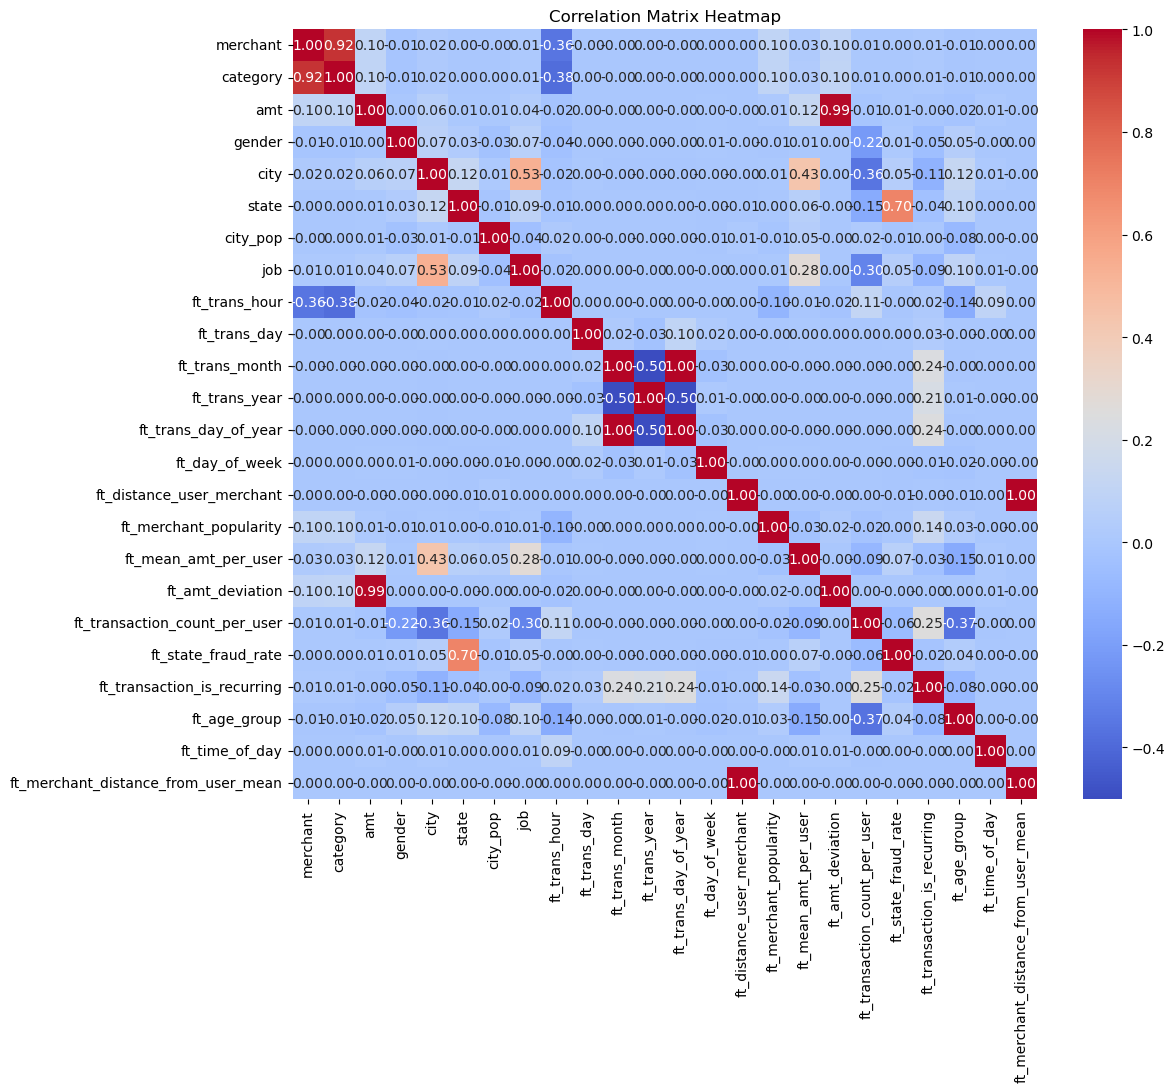

Highly Correlated Feature Pairs:
                               Feature_1                            Feature_2  \
1                               merchant                             category   
24                              category                             merchant   
65                                   amt                     ft_amt_deviation   
252                       ft_trans_month                 ft_trans_day_of_year   
298                 ft_trans_day_of_year                       ft_trans_month   
359            ft_distance_user_merchant  ft_merchant_distance_from_user_mean   
410                     ft_amt_deviation                                  amt   
566  ft_merchant_distance_from_user_mean            ft_distance_user_merchant   

     Correlation  
1       0.923883  
24      0.923883  
65      0.992205  
252     0.996813  
298     0.996813  
359     0.996967  
410     0.992205  
566     0.996967  


In [84]:
# Calculate the correlation matrix for the encoded training data
correlation_matrix = X_train_encoded.corr()

# Save the correlation matrix as a CSV file if needed
correlation_matrix.to_csv("correlation_matrix.csv", index=True)
print("Correlation matrix saved as 'correlation_matrix.csv'")

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Identify highly correlated features
threshold = 0.75  # Adjust threshold as needed
high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[
    (high_correlation_pairs['Correlation'] > threshold) & 
    (high_correlation_pairs['Feature_1'] != high_correlation_pairs['Feature_2'])
]

print("Highly Correlated Feature Pairs:")
print(high_correlation_pairs)

### 10.3 Feature Importance Analysis

In [85]:
##################
## EASIER WAY TO DO A QUICK CHECK ##
##################

# # Train XGBoost for feature importance
# xgb_model = XGBClassifier(random_state=42)
# xgb_model.fit(X_train_encoded, y_train)

# plot_importance(xgb_model, importance_type='weight', max_num_features=24)
# plt.title("Top 24 Feature Importance")
# plt.show()

In [86]:
# Step 1: Convert data into DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dval = xgb.DMatrix(X_val_encoded, label=y_val)

# Step 2: Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'auc',           # Metric to evaluate during training
    'max_depth': 6,                 # Tree depth
    'eta': 0.1,                     # Learning rate
    'subsample': 0.8,               # Subsample ratio
    'colsample_bytree': 0.8,        # Feature sampling ratio
    'seed': 42                      # Seed for reproducibility
}

# Step 3: Train the XGBoost model
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100, 
    evals=[(dval, 'validation')], 
    early_stopping_rounds=10,       # Stops if validation AUC doesn't improve
    verbose_eval=10
)

[0]	validation-auc:0.95907
[10]	validation-auc:0.98712
[20]	validation-auc:0.99216
[30]	validation-auc:0.99516
[40]	validation-auc:0.99595
[50]	validation-auc:0.99642
[56]	validation-auc:0.99650


Feature Importance Ranking:
amt: 406.0
ft_merchant_popularity: 314.0
city: 281.0
category: 274.0
ft_amt_deviation: 202.0
ft_trans_hour: 200.0
ft_mean_amt_per_user: 140.0
merchant: 117.0
ft_transaction_count_per_user: 105.0
ft_age_group: 100.0
city_pop: 92.0
job: 82.0
ft_trans_day_of_year: 58.0
ft_time_of_day: 42.0
ft_trans_day: 34.0
gender: 28.0
ft_distance_user_merchant: 23.0
ft_day_of_week: 20.0
state: 15.0
ft_merchant_distance_from_user_mean: 14.0
ft_state_fraud_rate: 11.0
ft_trans_month: 6.0
ft_transaction_is_recurring: 4.0
ft_trans_year: 2.0
*********************


<Figure size 2000x1600 with 0 Axes>

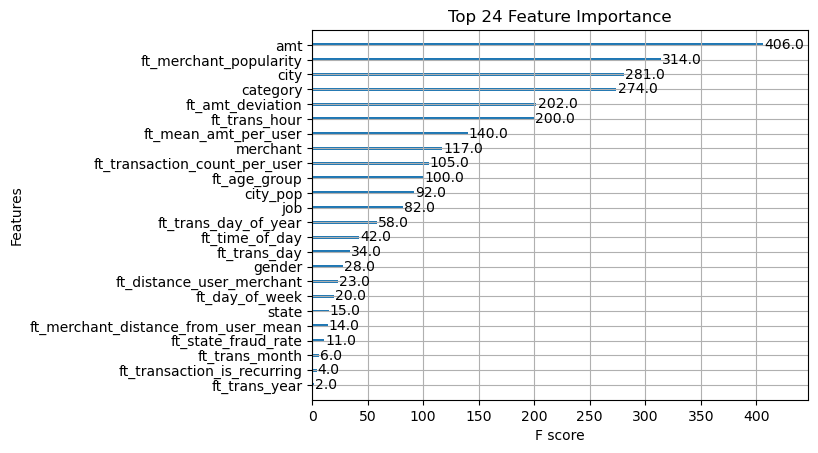

In [87]:
# Retrieve feature importance
feature_importance = model.get_score(importance_type='weight')  # Options: 'weight', 'gain', 'cover'

# Sort feature importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance Ranking:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

print('*********************')

# Plot feature importance
plt.figure(figsize=(20, 16))
plot_importance(model, importance_type='weight', max_num_features=24)  # Top 10 features
plt.title("Top 24 Feature Importance")
plt.show()

## 11. Identify the metric the model for your use case
- you can use a standard or a combination of standard metrics
- you may also define a custom metric based on your use case and data set

### 11.1 Primary chosen metric
- We chose **Recall**/**Sensitivity** as the primary standard metric
- **Reason**:

### 11.2 Supplimental Custom Metric - Weighted Cost-Aware Accuracy ($ value)

The **Weighted Cost-Aware Accuracy (WCAA)** is a custom metric designed to evaluate model performance by incorporating the financial impact of False Negatives (FN) and False Positives (FP). This metric is particularly useful in fraud detection, where missing fraud cases (FN) incurs significant costs, and false alarms (FP) can impact customer experience.

#### Formula:
\[
WCAA = -(FN\_Cost + FP\_Cost)
\]

- **FN Cost**: Calculated as the number of False Negatives multiplied by the average fraud loss (\(FN\_Cost = FN \times Avg\_Fraud\_Loss\)).
- **FP Cost**: Calculated as the number of False Positives multiplied by a percentage of the average fraud loss (\(FP\_Cost = FP \times Avg\_Fraud\_Loss \times FP\_Cost\_Ratio\)).

#### Key Parameters:
- **`avg_fraud_loss`**: The average financial loss per undetected fraud case.
- **`fp_cost_ratio`**: A fraction representing the inconvenience cost of a False Positive relative to the average fraud loss.

#### Use Case:
The WCAA metric provides a **dollar-value impact** of model performance, helping stakeholders understand the trade-offs between False Negatives and False Positives in financial terms. It supplements technical metrics like Recall, ensuring alignment with business objectives by minimizing total costs.

#### Example:
For a confusion matrix:

\[
\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}
\]

The WCAA metric evaluates:
- The cost of missed fraud cases (FN).
- The cost of incorrect fraud alerts (FP).
- Lower WCAA values indicate better cost-sensitive model performance.

In [88]:
# Function: to define the custom metric WCAA
def weighted_cost_aware_accuracy(conf_matrix, avg_fraud_loss=531.32, fp_cost_ratio=0.05):
    # Extract values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()  # tn: True Negatives, fp: False Positives, fn: False Negatives, tp: True Positives

    # Calculate the cost of False Negatives (missed frauds)
    fn_cost = fn * avg_fraud_loss

    # Calculate the cost of False Positives (incorrect fraud alerts)
    # False Positive cost is a percentage of the average fraud loss (e.g., inconvenience cost)
    fp_cost = fp * avg_fraud_loss * fp_cost_ratio

    # Return the negative total cost (to represent a "cost-aware accuracy")
    # Lower costs indicate better model performance
    return -(fn_cost + fp_cost)

## 12. Modeling

### 12.1 Baseline Model
- Run the baseline model with all features and document the key metrics

In [89]:
# Define XGBoost model
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # Default evaluation metric for XGBoost; we'll calculate recall separately
    #use_label_encoder=False,
    random_state=42
)

# Step 1: Train the model on the training dataset
xgb_classifier.fit(X_train_encoded, y_train)

# Step 2: Evaluate on Training and Validation Datasets
# Training Predictions
train_preds = xgb_classifier.predict(X_train_encoded)

# Validation Predictions
val_preds = xgb_classifier.predict(X_val_encoded)

# Calculate Recall
train_recall = recall_score(y_train, train_preds)
val_recall = recall_score(y_val, val_preds)

# Print Recall Scores
print(f"Training Recall: {train_recall:.3f}")
print(f"Validation Recall: {val_recall:.3f}")

# Step 3: Display the Confusion Matrix for Validation Data
conf_matrix = confusion_matrix(y_val, val_preds)
print("\nValidation Confusion Matrix:")
print(conf_matrix)

financial_impact = weighted_cost_aware_accuracy(conf_matrix)
print(f"\Financial Impact (Baseline): ${financial_impact:.2f}")

Training Recall: 0.947
Validation Recall: 0.833

Validation Confusion Matrix:
[[219118     42]
 [   213   1062]]

Financial Impact (Baseline): $-114286.93


#### Run the baseline model on test data as well to see if this model is good for the imbalanced dataset or not

In [124]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# Define XGBoost baseline model
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Step 1: Train the model on the training dataset
xgb_classifier.fit(X_train_encoded, y_train)

# Step 2: Evaluate on Training and Validation Datasets
train_preds = xgb_classifier.predict(X_train_encoded)
val_preds = xgb_classifier.predict(X_val_encoded)

train_recall = recall_score(y_train, train_preds)
val_recall = recall_score(y_val, val_preds)

print(f"Training Recall: {train_recall:.3f}")
print(f"Validation Recall: {val_recall:.3f}")

# Step 3: Display the Confusion Matrix for Validation Data
conf_matrix_val = confusion_matrix(y_val, val_preds)
print("\nValidation Confusion Matrix:")
print(conf_matrix_val)

financial_impact_val = weighted_cost_aware_accuracy(conf_matrix_val)
print(f"\nFinancial Impact (Baseline - Validation): ${financial_impact_val:.2f}")

# Step 4: Evaluate on the Test Dataset
test_preds = xgb_classifier.predict(X_test_encoded)
test_recall = recall_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
conf_matrix_test = confusion_matrix(y_test, test_preds)

print("\nTest Results for Baseline Model:")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

financial_impact_test = weighted_cost_aware_accuracy(conf_matrix_test)
print(f"\nFinancial Impact (Baseline - Test Set): ${financial_impact_test:.2f}")

Training Recall: 0.947
Validation Recall: 0.833

Validation Confusion Matrix:
[[219118     42]
 [   213   1062]]

Financial Impact (Baseline - Validation): $-114286.93

Test Results for Baseline Model:
Test Recall: 0.166
Test Precision: 0.851

Test Confusion Matrix:
[[193336     33]
 [   945    188]]

Financial Impact (Baseline - Test Set): $-502974.08


### 12.2 Feature Reduction
- Iteratively reduce features based on the level of importance
- document the results to identify best features

In [91]:
from sklearn.metrics import recall_score, confusion_matrix
import copy

# Initialize variables
remaining_features = list(X_train_encoded.columns)  # Start with all features
results = []  # To store results for each iteration

# Loop until only 10 features remain
while len(remaining_features) > 10:
    # Get the least important feature from the sorted feature importance
    least_important_feature = sorted_importance[-1][0]  # Get the last feature (least important)
    sorted_importance.pop()  # Remove it from the importance list

    # Remove the least important feature from the remaining feature set
    remaining_features.remove(least_important_feature)

    # Reduce the feature set in the training, validation, and test datasets
    X_train_reduced = X_train_encoded[remaining_features]
    X_val_reduced = X_val_encoded[remaining_features]

    # Define and train the XGBoost model
    xgb_classifier = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )
    xgb_classifier.fit(X_train_reduced, y_train)

    # Get predictions
    train_preds = xgb_classifier.predict(X_train_reduced)
    val_preds = xgb_classifier.predict(X_val_reduced)

    # Calculate metrics
    train_recall = recall_score(y_train, train_preds)
    val_recall = recall_score(y_val, val_preds)

    # Get the confusion matrix
    conf_matrix = confusion_matrix(y_val, val_preds)

    # Calculate the financial impact
    financial_impact = weighted_cost_aware_accuracy(conf_matrix)

    # Save results
    results.append({
        "remaining_features": len(remaining_features),
        "removed_feature": least_important_feature,
        "training_recall": train_recall,
        "validation_recall": val_recall,
        "confusion_matrix": conf_matrix,
        "financial_impact": financial_impact
    })

    # Print iteration result
    print(f"Remaining Features: {len(remaining_features)}")
    print(f"Removed Feature: {least_important_feature}")
    print(f"Training Recall: {train_recall:.3f}")
    print(f"Validation Recall: {val_recall:.3f}")
    print("Validation Confusion Matrix:")
    print(conf_matrix)
    print(f"Financial Impact: ${financial_impact:.2f}")
    print("-" * 50)

results_df = pd.DataFrame(results)

# Save results to a CSV file if needed
results_df.to_csv("feature_reduction_results.csv", index=False)
print("Feature reduction results saved as 'feature_reduction_results.csv'.")

# Print final remaining features
print("\nFinal Remaining Features:")
print(remaining_features)

Remaining Features: 23
Removed Feature: ft_trans_year
Training Recall: 0.937
Validation Recall: 0.813
Validation Confusion Matrix:
[[219120     40]
 [   239   1036]]
Financial Impact: $-128048.12
--------------------------------------------------
Remaining Features: 22
Removed Feature: ft_transaction_is_recurring
Training Recall: 0.949
Validation Recall: 0.835
Validation Confusion Matrix:
[[219120     40]
 [   211   1064]]
Financial Impact: $-113171.16
--------------------------------------------------
Remaining Features: 21
Removed Feature: ft_trans_month
Training Recall: 0.949
Validation Recall: 0.835
Validation Confusion Matrix:
[[219120     40]
 [   211   1064]]
Financial Impact: $-113171.16
--------------------------------------------------
Remaining Features: 20
Removed Feature: ft_state_fraud_rate
Training Recall: 0.950
Validation Recall: 0.827
Validation Confusion Matrix:
[[219115     45]
 [   221   1054]]
Financial Impact: $-118617.19
------------------------------------------

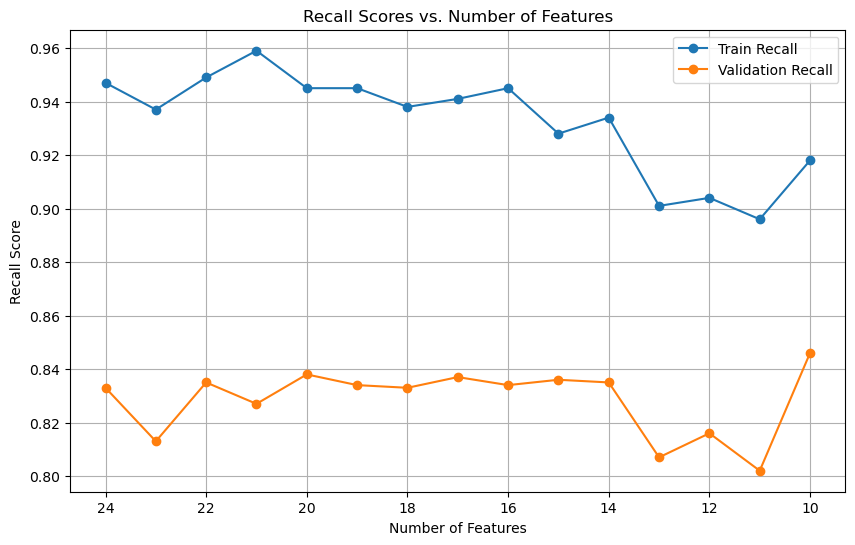

In [156]:
### THIS STEP IS DONE MANUALLY ####
### It needs to be improved to append result list programmatically ###

import matplotlib.pyplot as plt
import pandas as pd

# Simulated example data for demonstration
data = {
    "remaining_features": [24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10],
    "training_recall": [0.947, 0.937, 0.949, 0.959, 0.945, 0.945, 0.938, 0.941, 0.945, 0.928, 0.934, 0.901, 0.904, 0.896, 0.918],
    "validation_recall": [0.833, 0.813, 0.835, 0.827, 0.838, 0.834, 0.833, 0.837, 0.834, 0.836, 0.835, 0.807, 0.816, 0.802, 0.846],
    # "test_recall": [0.166, 0.52, 0.48, 0.50, 0.47, 0.49, 0.48, 0.51, 0.50, 0.48, 0.46, 0.44, 0.45, 0.43, 0.42]
}

results_df = pd.DataFrame(data)

# Plotting the Recall Scores vs. Number of Features
plt.figure(figsize=(10, 6))
plt.plot(results_df["remaining_features"], results_df["training_recall"], label="Train Recall", marker='o')
plt.plot(results_df["remaining_features"], results_df["validation_recall"], label="Validation Recall", marker='o')
# plt.plot(results_df["remaining_features"], results_df["test_recall"], label="Test Recall", marker='o')

plt.title("Recall Scores vs. Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Recall Score")
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show feature reduction
plt.grid(True)
plt.show()

### 12.3 Model for the best features:
- Identify the best features based on:
    - previous feature reduction step with best results
    - further eliminate any features with high colinearity (redundancy) to eliminate noise
    - document the results

In [150]:
# Define the final features list
final_features = [
    "amt", "ft_merchant_popularity", "city", "category",
    "ft_trans_hour", "ft_mean_amt_per_user", "ft_transaction_count_per_user",
    "ft_age_group", "city_pop", "job", "ft_trans_day_of_year", "ft_time_of_day"
]

# Reduce the datasets to only include the final features
X_train_final = X_train_encoded[final_features]
X_val_final = X_val_encoded[final_features]
X_test_final = X_test_encoded[final_features]

# Define the XGBoost model
xgb_classifier_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Train the model on the training dataset
xgb_classifier_final.fit(X_train_final, y_train)

# Evaluate the model on training, validation, and test datasets
# Training Predictions
train_preds_final = xgb_classifier_final.predict(X_train_final)
train_recall_final = recall_score(y_train, train_preds_final)

# Validation Predictions
val_preds_final = xgb_classifier_final.predict(X_val_final)
val_recall_final = recall_score(y_val, val_preds_final)

# Test Predictions
test_preds_final = xgb_classifier_final.predict(X_test_final)
test_recall_final = recall_score(y_test, test_preds_final)

# Calculate precision for test set
test_precision_final = precision_score(y_test, test_preds_final)

# Display results
print(f"Training Recall (Final Model): {train_recall_final:.3f}")
print(f"Validation Recall (Final Model): {val_recall_final:.3f}")
print(f"Test Recall (Final Model): {test_recall_final:.3f}")
print(f"Test Precision (Final Model): {test_precision_final:.3f}")

# Display the confusion matrix for validation data
conf_matrix_val_final = confusion_matrix(y_val, val_preds_final)
print("\nValidation Confusion Matrix (Final Model):")
print(conf_matrix_val_final)

# Display the confusion matrix for test data
conf_matrix_test_final = confusion_matrix(y_test, test_preds_final)
print("\nTest Confusion Matrix (Final Model):")
print(conf_matrix_test_final)

# Calculate the financial impact using the custom metric for validation and test sets
financial_impact_val_final = weighted_cost_aware_accuracy(conf_matrix_val_final)
financial_impact_test_final = weighted_cost_aware_accuracy(conf_matrix_test_final)

print(f"\nFinancial Impact (Validation Set - Final Model): ${financial_impact_val_final:.2f}")
print(f"Financial Impact (Test Set - Final Model): ${financial_impact_test_final:.2f}")

Training Recall (Final Model): 0.918
Validation Recall (Final Model): 0.846
Test Recall (Final Model): 0.158
Test Precision (Final Model): 0.758

Validation Confusion Matrix (Final Model):
[[219113     47]
 [   196   1079]]

Test Confusion Matrix (Final Model):
[[193312     57]
 [   954    179]]

Financial Impact (Validation Set - Final Model): $-105387.32
Financial Impact (Test Set - Final Model): $-508393.54


#### 12.3a Model for the best features based on Adaboost ranking

In [148]:
# from sklearn.metrics import recall_score, precision_score, confusion_matrix

# # Define the final features list
# adaBoost_ranked_features = [
#     "amt", "category", "ft_trans_hour", "ft_time_of_day"
# ]

# # Reduce the datasets to only include the final features
# X_train_ada_final = X_train_encoded[adaBoost_ranked_features]
# X_val_ada_final = X_val_encoded[adaBoost_ranked_features]
# X_test_ada_final = X_test_encoded[adaBoost_ranked_features]

# # Define the XGBoost model
# xgb_classifier_final = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     random_state=42
# )

# # Train the model on the training dataset
# xgb_classifier_final.fit(X_train_ada_final, y_train)

# # Evaluate the model on the training dataset
# train_preds_final = xgb_classifier_final.predict(X_train_ada_final)
# train_recall_final = recall_score(y_train, train_preds_final)
# print(f"Training Recall (Final Model): {train_recall_final:.3f}")

# # Evaluate the model on the validation dataset
# val_preds_final = xgb_classifier_final.predict(X_val_ada_final)
# val_recall_final = recall_score(y_val, val_preds_final)
# print(f"Validation Recall (Final Model): {val_recall_final:.3f}")

# # Evaluate the model on the test dataset
# test_preds_final = xgb_classifier_final.predict(X_test_ada_final)
# test_recall_final = recall_score(y_test, test_preds_final)
# test_precision_final = precision_score(y_test, test_preds_final)

# # Display results for test set
# print(f"Test Recall (Final Model): {test_recall_final:.3f}")
# print(f"Test Precision (Final Model): {test_precision_final:.3f}")

# # Confusion matrices for validation and test data
# conf_matrix_val_final = confusion_matrix(y_val, val_preds_final)
# conf_matrix_test_final = confusion_matrix(y_test, test_preds_final)

# print("\nValidation Confusion Matrix (Final Model):")
# print(conf_matrix_val_final)

# print("\nTest Confusion Matrix (Final Model):")
# print(conf_matrix_test_final)

# # Calculate the financial impact using the custom metric
# financial_impact_val_final = weighted_cost_aware_accuracy(conf_matrix_val_final)
# financial_impact_test_final = weighted_cost_aware_accuracy(conf_matrix_test_final)

# print(f"\nFinancial Impact (Validation Set - Final Model): ${financial_impact_val_final:.2f}")
# print(f"Financial Impact (Test Set - Final Model): ${financial_impact_test_final:.2f}")

Training Recall (Final Model): 0.707
Validation Recall (Final Model): 0.689
Test Recall (Final Model): 0.690
Test Precision (Final Model): 0.845

Validation Confusion Matrix (Final Model):
[[219017    143]
 [   396    879]]

Test Confusion Matrix (Final Model):
[[193226    143]
 [   351    782]]

Financial Impact (Validation Set - Final Model): $-214201.66
Financial Impact (Test Set - Final Model): $-190292.26


## 13. Hyperparameter Tuning

### 13.1 Gridsearch Tuning

In [93]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import recall_score
# import xgboost as xgb

# Selected Features
final_features = [
     "amt", "ft_merchant_popularity", "city", "category",
    "ft_trans_hour", "ft_mean_amt_per_user", "ft_transaction_count_per_user",
    "ft_age_group", "city_pop", "job", "ft_trans_day_of_year", "ft_time_of_day"
]

X_train_selected = X_train_encoded[final_features]
X_val_selected = X_val_encoded[final_features]

# Step 1: Define the XGBoost classifier
xgb_classifier_grid = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')

# Step 2: Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Step 3: Define GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier_grid,
    param_grid=param_grid,
    scoring='recall',
    cv=3,   # 3-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Step 4: Fit GridSearchCV
print("Starting Grid Search...")
grid_search.fit(X_train_selected, y_train)

# Step 5: Get the best model and evaluate
best_model_grid = grid_search.best_estimator_
best_params_grid = grid_search.best_params_

# Evaluate on training and validation datasets
train_preds_grid = best_model_grid.predict(X_train_selected)
val_preds_grid = best_model_grid.predict(X_val_selected)

train_recall_grid = recall_score(y_train, train_preds_grid)
val_recall_grid = recall_score(y_val, val_preds_grid)

# Step 6: Print results
print("\nGridSearchCV Results:")
print(f"Best Parameters: {best_params_grid}")
print(f"Training Recall (GridSearchCV): {train_recall_grid:.3f}")
print(f"Validation Recall (GridSearchCV): {val_recall_grid:.3f}")

# Display Validation Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix_grid = confusion_matrix(y_val, val_preds_grid)
print("\nValidation Confusion Matrix (GridSearchCV):")
print(conf_matrix_grid)

# Calculate Financial Impact
financial_impact_grid = weighted_cost_aware_accuracy(conf_matrix_grid)
print(f"\nFinancial Impact (GridSearchCV): ${financial_impact_grid:.2f}")

Starting Grid Search...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits


python(61576) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



GridSearchCV Results:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Training Recall (GridSearchCV): 0.998
Validation Recall (GridSearchCV): 0.865

Validation Confusion Matrix (GridSearchCV):
[[219122     38]
 [   172   1103]]

Financial Impact (GridSearchCV): $-92396.55


### 13.2 RandomizedSearch Tuning
- Take inputs from the result of GridSearch Tuning and further improve here

In [94]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, confusion_matrix
import xgboost as xgb
import numpy as np

# Define the updated parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': np.linspace(0.05, 0.25, 5),  # Slightly lower range around 0.2
    'max_depth': [3, 5, 6],  # Reduce depth to prevent overfitting
    'n_estimators': [200, 300, 400],  # Broaden the range for further tuning
    'subsample': [0.6, 0.8, 0.9],  # Reduce subsampling to prevent overfitting
    'colsample_bytree': [0.6, 0.8, 0.9],  # Lower feature sampling to reduce complexity
    'reg_alpha': [0.1, 0.5, 1, 5, 10],  # Higher L1 regularization to reduce overfitting
    'reg_lambda': [1, 2, 5, 10, 20]  # Higher L2 regularization to stabilize the model
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  # Recall will be evaluated separately
    random_state=42
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    scoring='recall',
    cv=3,  # 3-fold cross-validation
    n_iter=50,  # Number of random combinations to try
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
print("Starting Random Search...")
random_search.fit(X_train_selected, y_train)

# Retrieve the best model and parameters
best_model_random = random_search.best_estimator_
best_params_random = random_search.best_params_

# Evaluate the best model on training and validation sets
train_preds_random = best_model_random.predict(X_train_selected)
val_preds_random = best_model_random.predict(X_val_selected)

train_recall_random = recall_score(y_train, train_preds_random)
val_recall_random = recall_score(y_val, val_preds_random)

# Print the results
print("\nRandomizedSearchCV Results:")
print(f"Best Parameters: {best_params_random}")
print(f"Training Recall (RandomizedSearchCV): {train_recall_random:.3f}")
print(f"Validation Recall (RandomizedSearchCV): {val_recall_random:.3f}")

# Confusion Matrix
conf_matrix_random = confusion_matrix(y_val, val_preds_random)
print("\nValidation Confusion Matrix (RandomizedSearchCV):")
print(conf_matrix_random)

# Calculate Financial Impact
financial_impact_random = weighted_cost_aware_accuracy(conf_matrix_random)
print(f"\nFinancial Impact (RandomizedSearchCV): ${financial_impact_random:.2f}")

Starting Random Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


python(62053) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(62060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



RandomizedSearchCV Results:
Best Parameters: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Training Recall (RandomizedSearchCV): 0.978
Validation Recall (RandomizedSearchCV): 0.875

Validation Confusion Matrix (RandomizedSearchCV):
[[219120     40]
 [   160   1115]]

Financial Impact (RandomizedSearchCV): $-86073.84


### Test set run based on adaboost ranked features and hypertuned parameters

In [149]:
# from sklearn.metrics import recall_score, precision_score, confusion_matrix

# # Define the final features list
# adaBoost_ranked_features = [
#     "amt", "category", "ft_trans_hour", "ft_time_of_day"
# ]

# # Reduce the datasets to only include the final features
# X_train_final = X_train_encoded[adaBoost_ranked_features]
# X_val_final = X_val_encoded[adaBoost_ranked_features]
# X_test_final = X_test_encoded[adaBoost_ranked_features]

# # Define the XGBoost model with the best hyperparameters from RandomizedSearchCV
# xgb_classifier_final = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     subsample=0.9,
#     reg_lambda=1,
#     reg_alpha=0.5,
#     n_estimators=400,
#     max_depth=5,
#     learning_rate=0.2,
#     colsample_bytree=0.9,
#     random_state=42
# )

# # Train the model on the training dataset
# xgb_classifier_final.fit(X_train_final, y_train)

# # Evaluate the model on the training dataset
# train_preds_final = xgb_classifier_final.predict(X_train_final)
# train_recall_final = recall_score(y_train, train_preds_final)
# print(f"Training Recall (Final Model): {train_recall_final:.3f}")

# # Evaluate the model on the validation dataset
# val_preds_final = xgb_classifier_final.predict(X_val_final)
# val_recall_final = recall_score(y_val, val_preds_final)
# print(f"Validation Recall (Final Model): {val_recall_final:.3f}")

# # Evaluate the model on the test dataset
# test_preds_final = xgb_classifier_final.predict(X_test_final)
# test_recall_final = recall_score(y_test, test_preds_final)
# test_precision_final = precision_score(y_test, test_preds_final)

# # Display results for the test set
# print(f"Test Recall (Final Model): {test_recall_final:.3f}")
# print(f"Test Precision (Final Model): {test_precision_final:.3f}")

# # Confusion matrices for validation and test data
# conf_matrix_val_final = confusion_matrix(y_val, val_preds_final)
# conf_matrix_test_final = confusion_matrix(y_test, test_preds_final)

# print("\nValidation Confusion Matrix (Final Model):")
# print(conf_matrix_val_final)

# print("\nTest Confusion Matrix (Final Model):")
# print(conf_matrix_test_final)

# # Calculate the financial impact using the custom metric
# financial_impact_val_final = weighted_cost_aware_accuracy(conf_matrix_val_final)
# financial_impact_test_final = weighted_cost_aware_accuracy(conf_matrix_test_final)

# print(f"\nFinancial Impact (Validation Set - Final Model): ${financial_impact_val_final:.2f}")
# print(f"Financial Impact (Test Set - Final Model): ${financial_impact_test_final:.2f}")

Training Recall (Final Model): 0.700
Validation Recall (Final Model): 0.681
Test Recall (Final Model): 0.688
Test Precision (Final Model): 0.851

Validation Confusion Matrix (Final Model):
[[219024    136]
 [   407    868]]

Test Confusion Matrix (Final Model):
[[193233    136]
 [   354    779]]

Financial Impact (Validation Set - Final Model): $-219860.22
Financial Impact (Test Set - Final Model): $-191700.26


## 14. Model Testing on Test Set

#### 14.1 compare & drop irrelvant features

In [96]:
print("Training Features:", X_train_val_final.columns)
print("Testing Features:", X_test_final.columns)

Training Features: Index(['amt', 'ft_merchant_popularity', 'city', 'category', 'ft_trans_hour',
       'ft_mean_amt_per_user', 'ft_transaction_count_per_user', 'ft_age_group',
       'city_pop', 'job', 'ft_trans_day_of_year', 'ft_time_of_day'],
      dtype='object')
Testing Features: Index(['amt', 'ft_merchant_popularity', 'category', 'city', 'ft_trans_hour',
       'ft_mean_amt_per_user', 'ft_age_group', 'city_pop',
       'ft_transaction_count_per_user', 'job', 'ft_trans_day_of_year',
       'ft_trans_day'],
      dtype='object')


In [97]:
# Drop irrelevant columns from training and test datasets
X_train_val_final = X_train_val_final.drop(columns=['ft_time_of_day'], errors='ignore')
X_test_final = X_test_final.drop(columns=['ft_trans_day'], errors='ignore')

# Confirm alignment of features
print("Aligned Training Features:", X_train_val_final.columns)
print("Aligned Testing Features:", X_test_final.columns)

Aligned Training Features: Index(['amt', 'ft_merchant_popularity', 'city', 'category', 'ft_trans_hour',
       'ft_mean_amt_per_user', 'ft_transaction_count_per_user', 'ft_age_group',
       'city_pop', 'job', 'ft_trans_day_of_year'],
      dtype='object')
Aligned Testing Features: Index(['amt', 'ft_merchant_popularity', 'category', 'city', 'ft_trans_hour',
       'ft_mean_amt_per_user', 'ft_age_group', 'city_pop',
       'ft_transaction_count_per_user', 'job', 'ft_trans_day_of_year'],
      dtype='object')


#### 14.2 Final Test

In [99]:
# Align the column order of the test dataset with the training dataset
X_test_final = X_test_final[X_train_val_final.columns]

# Confirm alignment
print("Aligned Training Features:", list(X_train_val_final.columns))
print("Aligned Testing Features:", list(X_test_final.columns))

# Re-train the final model on the aligned training dataset
print("Training the final model on combined training and validation datasets...")
final_model.fit(X_train_val_final, y_train_val_final)

# Test the model on the aligned test dataset
test_preds = final_model.predict(X_test_final)

# Evaluate metrics
from sklearn.metrics import recall_score, confusion_matrix

test_recall = recall_score(y_test, test_preds)
conf_matrix_test = confusion_matrix(y_test, test_preds)

# Display results
print("\nFinal Test Results:")
print(f"Test Recall: {test_recall:.3f}")
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Calculate Financial Impact on the Test Set
financial_impact_test = weighted_cost_aware_accuracy(conf_matrix_test)
print(f"\nFinancial Impact on Test Set: ${financial_impact_test:.2f}")

Aligned Training Features: ['amt', 'ft_merchant_popularity', 'city', 'category', 'ft_trans_hour', 'ft_mean_amt_per_user', 'ft_transaction_count_per_user', 'ft_age_group', 'city_pop', 'job', 'ft_trans_day_of_year']
Aligned Testing Features: ['amt', 'ft_merchant_popularity', 'city', 'category', 'ft_trans_hour', 'ft_mean_amt_per_user', 'ft_transaction_count_per_user', 'ft_age_group', 'city_pop', 'job', 'ft_trans_day_of_year']
Training the final model on combined training and validation datasets...

Final Test Results:
Test Recall: 0.180

Test Confusion Matrix:
[[193307     62]
 [   929    204]]

Financial Impact on Test Set: $-495243.37


## 15 Post test Improvment - Advanced Techniques

### 15.1 Option 1: SMOTE with Class Weighting
- SMOTE: Synthetic Minority Oversampling Tecnhique
- Class Weighting: Assign higher weights to the minority class during training so the model focuses more on it

In [103]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score

# Step 1: Use SMOTE to Oversample the Minority Class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_val_final, y_train_val_final)

# Confirm the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Step 2: Calculate scale_pos_weight for XGBoost
scale_pos_weight = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]

# Step 3: Define the XGBoost Model with scale_pos_weight
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    colsample_bytree=0.8,   # Replace with your best parameters
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    reg_alpha=5,
    reg_lambda=10,
    subsample=0.8
)

# Step 4: Train the model on the balanced dataset
print("Training the model with SMOTE and class weighting...")
final_model.fit(X_train_balanced, y_train_balanced)

# Step 5: Test the model on the original test dataset
test_preds = final_model.predict(X_test_final)

# Step 6: Evaluate Metrics on the Test Set
test_recall = recall_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
conf_matrix_test = confusion_matrix(y_test, test_preds)

# Print Results
print("\nFinal Test Results After SMOTE and Class Weighting:")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Calculate Financial Impact on the Test Set
financial_impact_test = weighted_cost_aware_accuracy(conf_matrix_test)
print(f"\nFinancial Impact on Test Set After Balancing: ${financial_impact_test:.2f}")

Class distribution after SMOTE:
is_fraud
0    1095800
1    1095800
Name: count, dtype: int64
Training the model with SMOTE and class weighting...

Final Test Results After SMOTE and Class Weighting:
Test Recall: 0.176
Test Precision: 0.163

Test Confusion Matrix:
[[192347   1022]
 [   934    199]]

Financial Impact on Test Set After Balancing: $-523403.33


### 15.1 Options 2: Class Weighting Only
- Remove SMOTE and Rely on scale_pos_weight Alone

In [104]:
# Calculate scale_pos_weight from the original training data
scale_pos_weight = y_train_val_final.value_counts()[0] / y_train_val_final.value_counts()[1]

# Define the XGBoost Model with scale_pos_weight
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    colsample_bytree=0.8,   # Replace with best parameters
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    reg_alpha=5,
    reg_lambda=10,
    subsample=0.8
)

# Train the model on the original training dataset
print("Training the model with scale_pos_weight only...")
final_model.fit(X_train_val_final, y_train_val_final)

# Test the model on the original test dataset
test_preds = final_model.predict(X_test_final)

# Evaluate Metrics
test_recall = recall_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
conf_matrix_test = confusion_matrix(y_test, test_preds)

# Print Results
print("\nFinal Test Results with scale_pos_weight:")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Financial Impact
financial_impact_test = weighted_cost_aware_accuracy(conf_matrix_test)
print(f"\nFinancial Impact on Test Set: ${financial_impact_test:.2f}")

Training the model with scale_pos_weight only...

Final Test Results with scale_pos_weight:
Test Recall: 0.186
Test Precision: 0.112

Test Confusion Matrix:
[[191694   1675]
 [   922    211]]

Financial Impact on Test Set: $-534375.09


### 15.1 - Option 3 - Use Focal Loss in XGBoost
- Use focal loss to focus more on harder-to-classify examples (e.g., fraud).

In [107]:
## Step 1: Define Focal Loss

import numpy as np
import xgboost as xgb

# Define focal loss
def focal_loss(preds, dtrain, alpha=0.25, gamma=2):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))  # Transform predictions into probabilities

    # Compute gradients and hessians element-wise
    grad = alpha * (preds - labels) * (labels * ((1 - preds) ** gamma) + (1 - labels) * (preds ** gamma))
    hess = alpha * (labels * (1 - preds) ** (gamma - 1) * preds * (1 - preds) +
                    (1 - labels) * preds ** (gamma - 1) * preds * (1 - preds))

    return grad, hess
    return grad, hess

# Custom evaluation metric for logging
def focal_loss_metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))  # Transform predictions into probabilities

    # Calculate focal loss metric
    loss = -(alpha * labels * ((1 - preds) ** gamma) * np.log(preds + 1e-8) +
             alpha * (1 - labels) * (preds ** gamma) * np.log(1 - preds + 1e-8))
    return 'focal_loss', np.mean(loss)

In [108]:
## Step 2: Train XGBoost Model with Focal Loss

# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10,
    'alpha': 5
}

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train_val_final, label=y_train_val_final)
dtest = xgb.DMatrix(X_test_final, label=y_test)

# Train the model
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    obj=focal_loss,  # Use corrected focal loss
    evals=[(dtest, 'test')],
    verbose_eval=10
)

# Predict on test set
test_preds = (final_model.predict(dtest) > 0.5).astype(int)

# Evaluate metrics
from sklearn.metrics import recall_score, precision_score, confusion_matrix

test_recall = recall_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
conf_matrix_test = confusion_matrix(y_test, test_preds)

# Print Results
print("\nFinal Test Results with Focal Loss:")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Financial Impact
financial_impact_test = weighted_cost_aware_accuracy(conf_matrix_test)
print(f"\nFinancial Impact on Test Set with Focal Loss: ${financial_impact_test:.2f}")

[0]	test-logloss:0.64548
[10]	test-logloss:0.38986
[20]	test-logloss:0.28517
[30]	test-logloss:0.22828
[40]	test-logloss:0.19297
[50]	test-logloss:0.16878
[60]	test-logloss:0.15108
[70]	test-logloss:0.13811
[80]	test-logloss:0.12821
[90]	test-logloss:0.12029
[100]	test-logloss:0.11362
[110]	test-logloss:0.10792
[120]	test-logloss:0.10321
[130]	test-logloss:0.09930
[140]	test-logloss:0.09604
[150]	test-logloss:0.09322
[160]	test-logloss:0.09054
[170]	test-logloss:0.08831
[180]	test-logloss:0.08636
[190]	test-logloss:0.08452
[200]	test-logloss:0.08291
[210]	test-logloss:0.08152
[220]	test-logloss:0.08015
[230]	test-logloss:0.07895
[240]	test-logloss:0.07798
[250]	test-logloss:0.07696
[260]	test-logloss:0.07601
[270]	test-logloss:0.07532
[280]	test-logloss:0.07444
[290]	test-logloss:0.07374
[299]	test-logloss:0.07316

Final Test Results with Focal Loss:
Test Recall: 0.153
Test Precision: 0.749

Test Confusion Matrix:
[[193311     58]
 [   960    173]]

Financial Impact on Test Set with Fo

#### Exploration Steps

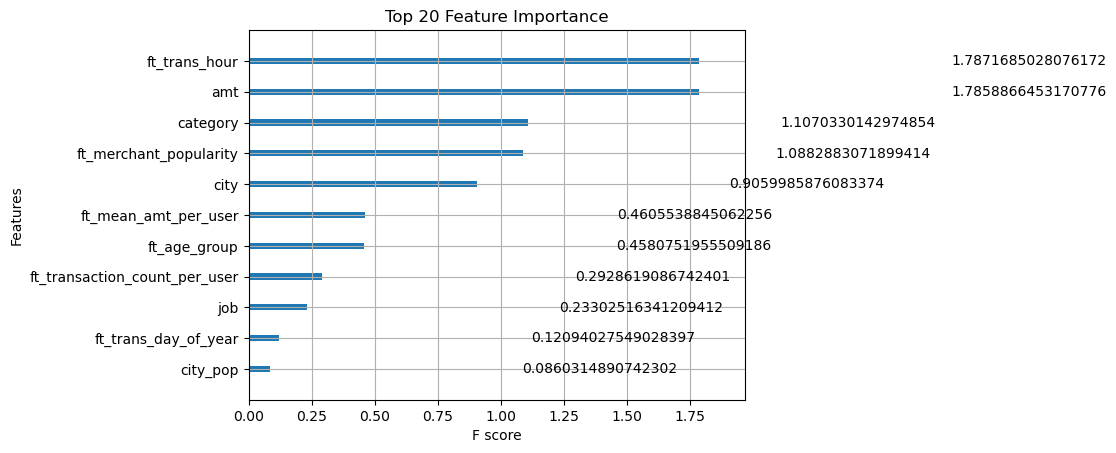

In [109]:
xgb.plot_importance(final_model, importance_type="gain", max_num_features=20)
plt.title("Top 20 Feature Importance")
plt.show()

In [112]:
# Count the number of fraud (1) and non-fraud (0) cases in the test set
fraud_counts = y_test.value_counts()
print("Test Set Class Distribution:")
print(fraud_counts)

# Optionally calculate percentage of fraud cases
fraud_percentage = (fraud_counts[1] / fraud_counts.sum()) * 100
print(f"\nPercentage of Fraud Cases in Test Set: {fraud_percentage:.2f}%")

Test Set Class Distribution:
is_fraud
0    193369
1      1133
Name: count, dtype: int64

Percentage of Fraud Cases in Test Set: 0.58%


### 15.1 - Option 4 - Use Stacked Model
- XGBClassifier
- BalancedRandomForest Classifer
- Logistic Regression

* Scale for Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scale features for Logistic Regression
scaler = StandardScaler()

# Create scaled logistic regression pipeline
lr_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('lr', LogisticRegression(random_state=42))
])

* Re-initialize XGBClassifier with the identified parameters in our final model

In [118]:
import xgboost as xgb

# Initialize XGBClassifier with the best parameters
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=0.5,
    n_estimators=400,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.9
)

# Retrain XGBClassifier
xgb_clf.fit(X_train_val_final, y_train_val_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

* initialize BalancedRandomForestClassifier
* create a voting ensemble classifier

In [121]:
from sklearn.ensemble import VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Initialize Balanced Random Forest
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Create a voting ensemble
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),              # Use the tuned XGBClassifier
    ('brf', brf),                  # Balanced Random Forest
    ('lr', lr_pipeline)            # Logistic Regression pipeline
], voting='soft')

# Train the Voting Classifier
voting_clf.fit(X_train_val_final, y_train_val_final)

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future beh

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('brf',
                              BalancedRandomForestClassifier(random_state=42)),
                             ('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(random_state=42))]))],
                 voting='soft')

* test the model

In [122]:
# Predict on the test set
test_preds = voting_clf.predict(X_test_final)

# Calculate metrics
test_recall = recall_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
conf_matrix_test = confusion_matrix(y_test, test_preds)

# Print results
print("\nFinal Test Results with Voting Classifier:")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"F1 Score: {test_f1:.3f}")
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Optional: Calculate Financial Impact
financial_impact_test = weighted_cost_aware_accuracy(conf_matrix_test)
print(f"\nFinancial Impact on Test Set with Voting Classifier: ${financial_impact_test:.2f}")


Final Test Results with Voting Classifier:
Test Recall: 0.154
Test Precision: 0.745
F1 Score: 0.256

Test Confusion Matrix:
[[193309     60]
 [   958    175]]

Financial Impact on Test Set with Voting Classifier: $-510598.52


## 16 Changing the basic variables to see if the results improve
- This is the point where we decide if it is worth changing basic variables like (split method, encoding method, feature importance method OR all together start with a new algorithm)

### 16.1 Change the Feature Importance method
* here we have used the most important feature selection by AdaBoost (instead of XGBoost) while keeping the same algorithm
* you can find the code for AdaBoost ranking in Simran's file

#### XGBClassifier Model for the best features based on Adaboost ranking

In [151]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# Define the final features list
adaBoost_ranked_features = [
    "amt", "category", "ft_trans_hour", "ft_time_of_day"
]

# Reduce the datasets to only include the final features
X_train_ada_final = X_train_encoded[adaBoost_ranked_features]
X_val_ada_final = X_val_encoded[adaBoost_ranked_features]
X_test_ada_final = X_test_encoded[adaBoost_ranked_features]

# Define the XGBoost model
xgb_classifier_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Train the model on the training dataset
xgb_classifier_final.fit(X_train_ada_final, y_train)

# Evaluate the model on the training dataset
train_preds_final = xgb_classifier_final.predict(X_train_ada_final)
train_recall_final = recall_score(y_train, train_preds_final)
print(f"Training Recall (Final Model): {train_recall_final:.3f}")

# Evaluate the model on the validation dataset
val_preds_final = xgb_classifier_final.predict(X_val_ada_final)
val_recall_final = recall_score(y_val, val_preds_final)
print(f"Validation Recall (Final Model): {val_recall_final:.3f}")

# Evaluate the model on the test dataset
test_preds_final = xgb_classifier_final.predict(X_test_ada_final)
test_recall_final = recall_score(y_test, test_preds_final)
test_precision_final = precision_score(y_test, test_preds_final)

# Display results for test set
print(f"Test Recall (Final Model): {test_recall_final:.3f}")
print(f"Test Precision (Final Model): {test_precision_final:.3f}")

# Confusion matrices for validation and test data
conf_matrix_val_final = confusion_matrix(y_val, val_preds_final)
conf_matrix_test_final = confusion_matrix(y_test, test_preds_final)

print("\nValidation Confusion Matrix (Final Model):")
print(conf_matrix_val_final)

print("\nTest Confusion Matrix (Final Model):")
print(conf_matrix_test_final)

# Calculate the financial impact using the custom metric
financial_impact_val_final = weighted_cost_aware_accuracy(conf_matrix_val_final)
financial_impact_test_final = weighted_cost_aware_accuracy(conf_matrix_test_final)

print(f"\nFinancial Impact (Validation Set - Final Model): ${financial_impact_val_final:.2f}")
print(f"Financial Impact (Test Set - Final Model): ${financial_impact_test_final:.2f}")

Training Recall (Final Model): 0.707
Validation Recall (Final Model): 0.689
Test Recall (Final Model): 0.690
Test Precision (Final Model): 0.845

Validation Confusion Matrix (Final Model):
[[219017    143]
 [   396    879]]

Test Confusion Matrix (Final Model):
[[193226    143]
 [   351    782]]

Financial Impact (Validation Set - Final Model): $-214201.66
Financial Impact (Test Set - Final Model): $-190292.26


### Test set run based on adaboost ranked features and hypertuned parameters

In [152]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# Define the final features list
adaBoost_ranked_features = [
    "amt", "category", "ft_trans_hour", "ft_time_of_day"
]

# Reduce the datasets to only include the final features
X_train_final = X_train_encoded[adaBoost_ranked_features]
X_val_final = X_val_encoded[adaBoost_ranked_features]
X_test_final = X_test_encoded[adaBoost_ranked_features]

# Define the XGBoost model with the best hyperparameters from RandomizedSearchCV
xgb_classifier_final = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    subsample=0.9,
    reg_lambda=1,
    reg_alpha=0.5,
    n_estimators=400,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.9,
    random_state=42
)

# Train the model on the training dataset
xgb_classifier_final.fit(X_train_final, y_train)

# Evaluate the model on the training dataset
train_preds_final = xgb_classifier_final.predict(X_train_final)
train_recall_final = recall_score(y_train, train_preds_final)
print(f"Training Recall (Final Model): {train_recall_final:.3f}")

# Evaluate the model on the validation dataset
val_preds_final = xgb_classifier_final.predict(X_val_final)
val_recall_final = recall_score(y_val, val_preds_final)
print(f"Validation Recall (Final Model): {val_recall_final:.3f}")

# Evaluate the model on the test dataset
test_preds_final = xgb_classifier_final.predict(X_test_final)
test_recall_final = recall_score(y_test, test_preds_final)
test_precision_final = precision_score(y_test, test_preds_final)

# Display results for the test set
print(f"Test Recall (Final Model): {test_recall_final:.3f}")
print(f"Test Precision (Final Model): {test_precision_final:.3f}")

# Confusion matrices for validation and test data
conf_matrix_val_final = confusion_matrix(y_val, val_preds_final)
conf_matrix_test_final = confusion_matrix(y_test, test_preds_final)

print("\nValidation Confusion Matrix (Final Model):")
print(conf_matrix_val_final)

print("\nTest Confusion Matrix (Final Model):")
print(conf_matrix_test_final)

# Calculate the financial impact using the custom metric
financial_impact_val_final = weighted_cost_aware_accuracy(conf_matrix_val_final)
financial_impact_test_final = weighted_cost_aware_accuracy(conf_matrix_test_final)

print(f"\nFinancial Impact (Validation Set - Final Model): ${financial_impact_val_final:.2f}")
print(f"Financial Impact (Test Set - Final Model): ${financial_impact_test_final:.2f}")

Training Recall (Final Model): 0.700
Validation Recall (Final Model): 0.681
Test Recall (Final Model): 0.688
Test Precision (Final Model): 0.851

Validation Confusion Matrix (Final Model):
[[219024    136]
 [   407    868]]

Test Confusion Matrix (Final Model):
[[193233    136]
 [   354    779]]

Financial Impact (Validation Set - Final Model): $-219860.22
Financial Impact (Test Set - Final Model): $-191700.26
